In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
#visualizing data HERE

from qiskit_algorithms.utils import algorithm_globals
import datetime

# Seed for reproducibility
algorithm_globals.random_seed = 12345

# Set up a random data provider
data = RandomDataProvider(
    tickers=["A", "B", "C", "D"],  # 4 random assets
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=algorithm_globals.random_seed,
)
data.run()  # Generates random prices and computes returns
print("Mean returns vector (μ):")
print(data.get_period_return_mean_vector())

print("\nCovariance matrix (Σ):")
print(data.get_period_return_covariance_matrix())

print("\nAll price time-series data:")
print(data._data)

#print(dir(data))

Mean returns vector (μ):
[ 0.0111167  -0.00034011 -0.00426325  0.00609023]

Covariance matrix (Σ):
[[ 9.57552878e-03 -1.26134945e-04 -1.02927882e-04  1.70409185e-04]
 [-1.26134945e-04  1.80154599e-04  2.83493773e-05 -8.64123649e-05]
 [-1.02927882e-04  2.83493773e-05  1.98938051e-04  2.97799831e-05]
 [ 1.70409185e-04 -8.64123649e-05  2.97799831e-05  8.01498340e-04]]

All price time-series data:
[[11.57617496354537, 12.83990342167448, 11.969241683715394, 11.710068448780996, 11.634725141770474, 10.893840489684866, 9.526047787901923, 10.174940590094963, 10.535998703149858, 8.583135640137668, 10.93054529451652, 11.899042200268443, 11.139655019843936, 12.041853294056189, 11.574900120735638, 11.51421060199861, 12.303054946517811, 11.046386813378135, 11.622244327774062, 13.021223322497782, 14.343521383230568, 14.043822867931462, 14.946742209356522, 13.325159475174317, 13.166970214497445, 13.61645414660412, 12.272853074117725, 12.191165483420892, 13.915905415737223], [60.77736134381077, 61.6059

| Quantity               | Symbol                  | Meaning                                                             |
| ---------------------- | ----------------------- | ------------------------------------------------------------------- |
| **Mean Return Vector** | **μ = [μ₁, μ₂, …, μₙ]** | Average (expected) return of each asset                             |
| **Covariance Matrix**  | **Σ = [σᵢⱼ]**           | How each pair of assets’ returns move together (risk relationships) |


In [3]:
# set number of assets[stocks] (which is none other than the = number of qubits)
num_assets = 4
seed = 123  #ensures reproducibility (the same random data every time we run it).

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)] #This creates a simple list of “fake” stock symbols:
print("Artificial STOCKS names: ", stocks)

#now generating synthetic data generator from qiskit_finance.data_providers
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)   #It simulates random stock price time-series for each ticker between Jan 1 and Jan 30, 2016 & randomness uses our seed to ensure reproducibility
data.run() #executes the random data generation
mu = data.get_period_return_mean_vector()  ## each number = average return per asset
sigma = data.get_period_return_covariance_matrix()  ##  # risk and correlation matrix

Artificial STOCKS names:  ['TICKER0', 'TICKER1', 'TICKER2', 'TICKER3']


In [4]:
##looking inside all the generated data

print("Mean returns vector (mu):")
print(data.get_period_return_mean_vector())

print("\nCovariance matrix (sigma):")
print(data.get_period_return_covariance_matrix())

print("\n Randomly generated price time-series data:")
if hasattr(data, "data"):
    df = data.data
else:
    df = data._data

print(df)

Mean returns vector (mu):
[ 0.01528439 -0.00078095  0.00051792  0.00087001]

Covariance matrix (sigma):
[[ 2.54138859e-03  7.34022167e-05  1.28600531e-04 -9.98612132e-05]
 [ 7.34022167e-05  2.58486713e-04  5.30427595e-05  4.44816208e-05]
 [ 1.28600531e-04  5.30427595e-05  7.91504681e-04 -1.23887382e-04]
 [-9.98612132e-05  4.44816208e-05 -1.23887382e-04  1.97892585e-04]]

 Randomly generated price time-series data:
[[16.01087864965215, 15.643091998184266, 16.931017259473514, 17.12499167860613, 18.045222578245983, 18.622326369503234, 17.985862723132257, 18.52781494354255, 18.211219492376735, 17.888830376217772, 17.98599769488823, 16.460067288369277, 17.652233392470936, 16.981143717296828, 17.981413136956288, 18.117734260809407, 19.649767340438203, 18.989797926646382, 18.678003070176462, 19.01577219673529, 16.808301098535484, 17.636222540094224, 19.17785293478484, 20.30465972804987, 21.059429372362118, 20.913451479246895, 22.19535370630661, 23.26938432827855, 23.662005172855824], [62.6382

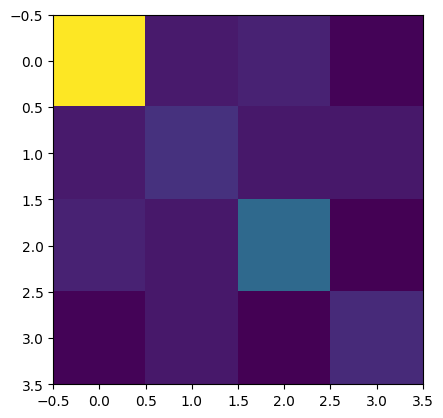

In [6]:
# plotting sigma data
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [7]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.001270694296030004*x_0^2 + 7.34022166934733e-05*..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [8]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


In [9]:
ansatz = TwoLocal(num_assets, "ry", "cz")
optimizer = COBYLA(maxiter=200)
vqe = SamplingVQE(Sampler(), ansatz, optimizer)
meo = MinimumEigenOptimizer(vqe)
result = meo.solve(qp)
print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 0 0]	-0.0130		0.5107
 [1 0 0 1]	-0.0149		0.2666
 [0 1 1 0]	0.0008		0.0703
 [1 0 1 0]	-0.0140		0.0430
 [0 0 1 1]	-0.0010		0.0264
 [1 1 0 1]	-0.0139		0.0254
 [0 1 0 0]	0.0009		0.0205
 [0 0 0 1]	-0.0008		0.0107
 [1 0 1 1]	-0.0150		0.0088
 [1 0 0 0]	-0.0140		0.0059
 [0 0 1 0]	-0.0001		0.0059
 [1 1 1 0]	-0.0130		0.0029
 [1 1 1 1]	-0.0139		0.0020
 [0 1 1 1]	-0.0000		0.0010
